In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import shapiro
import statsmodels.api as sm
import numpy as np


## Wczytanie danych

In [3]:
# Wczytaj dane z pliku CSV
predata = pd.read_csv('Prognoza.csv', sep=';' ,parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje tygodniowe 
data = predata.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()
# Wyświetl pierwsze kilka wierszy przetworzonych danych
print(data.head())

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Wyświetl pierwsze kilka wierszy przetworzonych danych
print(data.head())



      DATA_W    ILOSC  articles  customers
0 2022-01-03    7.072         7          3
1 2022-01-04  230.061       415         35
2 2022-01-05  115.141       411         37
3 2022-01-10  148.733       434         47
4 2022-01-11  505.648       896         53
        date    ilosc  articles  customers
0 2022-01-03    7.072         7          3
1 2022-01-04  230.061       415         35
2 2022-01-05  115.141       411         37
3 2022-01-10  148.733       434         47
4 2022-01-11  505.648       896         53


In [30]:
data.describe()

,date,ilosc,articles,customers
count,614,614.000000,614.000000,614.000000
mean,2023-03-24 21:36:56.286644992,638.307425,823.167752,59.705212
min,2022-01-03 00:00:00,-74.035000,1.000000,1.000000
25%,2022-08-13 00:00:00,181.441000,488.500000,52.000000
50%,2023-03-22 12:00:00,259.233000,636.500000,59.000000
75%,2023-11-01 12:00:00,556.146500,862.750000,67.000000
max,2024-06-18 00:00:00,7589.803000,4577.000000,124.000000
std,NaN,1023.765432,634.598299,16.194356


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       614 non-null    datetime64[ns]
 1   ilosc      614 non-null    float64       
 2   articles   614 non-null    int64         
 3   customers  614 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 19.3 KB


In [ ]:
import numpy as np
import pandas as pd

# Funkcja do wykrywania wartości odstających
def detect_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    for i in range(len(data)):
        z_score = (data[i] - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

# Wykrywanie wartości odstających w zestawie treningowym
outliers_indices = detect_outliers(data['ilosc'], 2)

# Wyświetlenie dat, w których występują wartości odstające
outliers_dates = data.iloc[outliers_indices]['date']
print(f"Dates with outliers: {outliers_dates}")

# Wyświetlenie wartości odstających
outliers_values = data.iloc[outliers_indices]['ilosc']
print(f"Outlier values: {outliers_values}")

# Łączenie dat z wartościami odstającymi w jednym DataFrame
outliers_info = pd.DataFrame({
    'Date': outliers_dates,
    'Outlier Value': outliers_values
})
print(outliers_info)


### Model regresji liniowej

* Cel: odkrycie zależności pomiędzy zmiennymi

In [33]:
# Definicja zmiennych niezależnych (X) i zmiennej zależnej (y)
X = data[['articles', 'customers']]
y = data['ilosc']

In [34]:
# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji liniowej
model = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2616.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          2.69e-300
Time:                        18:58:31   Log-Likelihood:                -4433.3
No. Observations:                 614   AIC:                             8873.
Df Residuals:                     611   BIC:                             8886.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        194.3499     52.696      3.688      0.0

### Macierz korelacji

Macierz korelacji:

           date  ilosc  articles  customers
date       1.00   0.01      0.08       0.33
ilosc      0.01   1.00      0.92       0.34
articles   0.08   0.92      1.00       0.56
customers  0.33   0.34      0.56       1.00


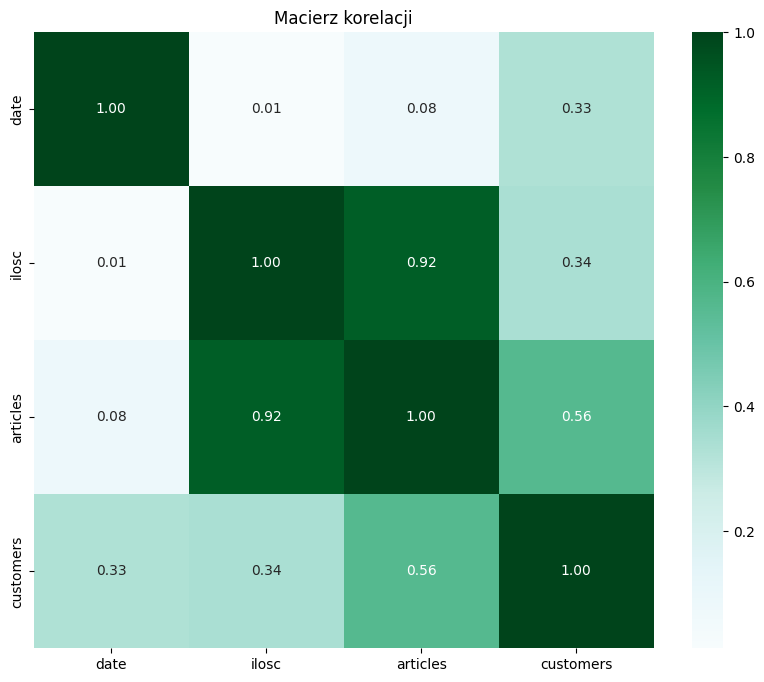

In [35]:
# Obliczanie macierzy korelacji
correlation_matrix = data.corr()

# Ładny wydruk macierzy korelacji
print("Macierz korelacji:\n")
print(correlation_matrix.to_string(float_format="%.2f"))

# Wizualizacja macierzy korelacji za pomocą mapy cieplnej
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuGn', fmt=".2f")
plt.title('Macierz korelacji')
plt.show()



### Histogram

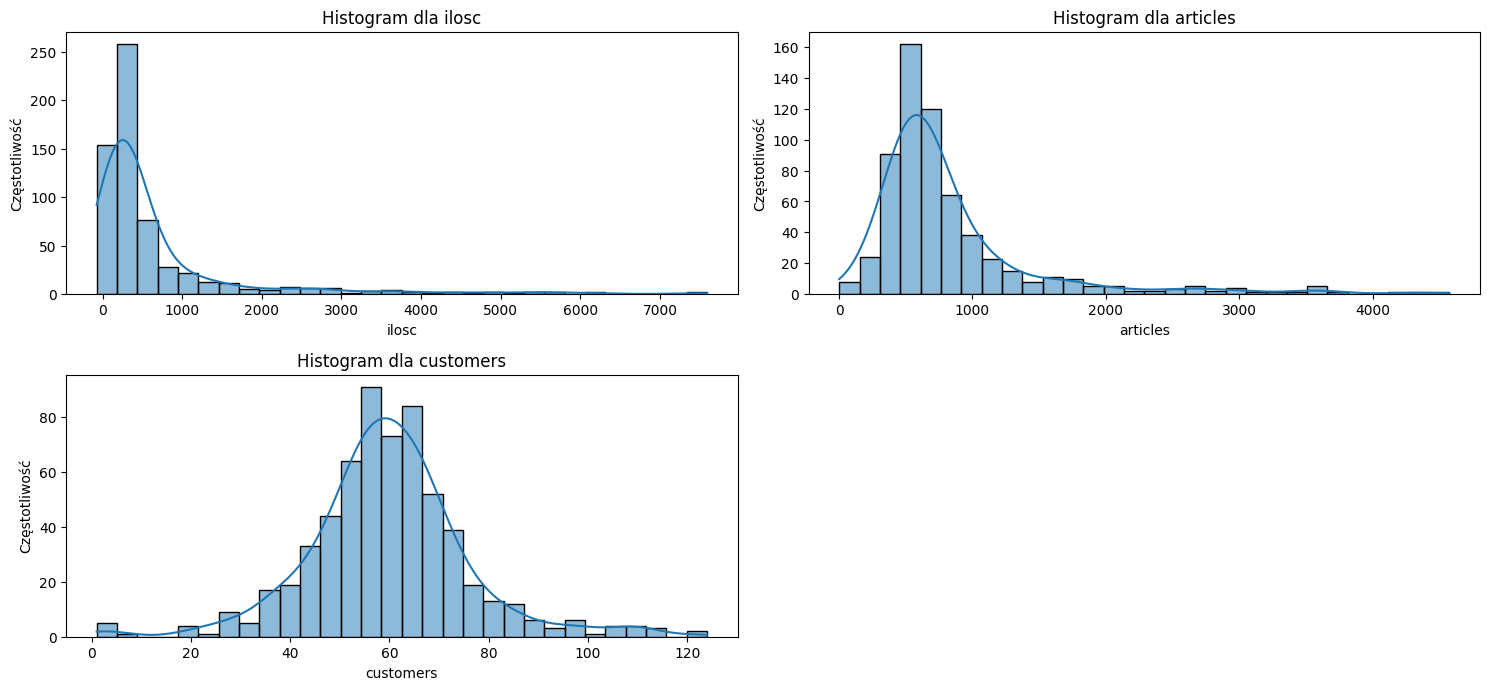

In [36]:
# Wybór kolumn do stworzenia histogramów
columns_to_plot = ['ilosc', 'articles', 'customers']

# Tworzenie histogramów dla wybranych kolumn
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Histogram dla {column}')
    plt.xlabel(column)
    plt.ylabel('Częstotliwość')

plt.tight_layout()
plt.show()

### Boxplot

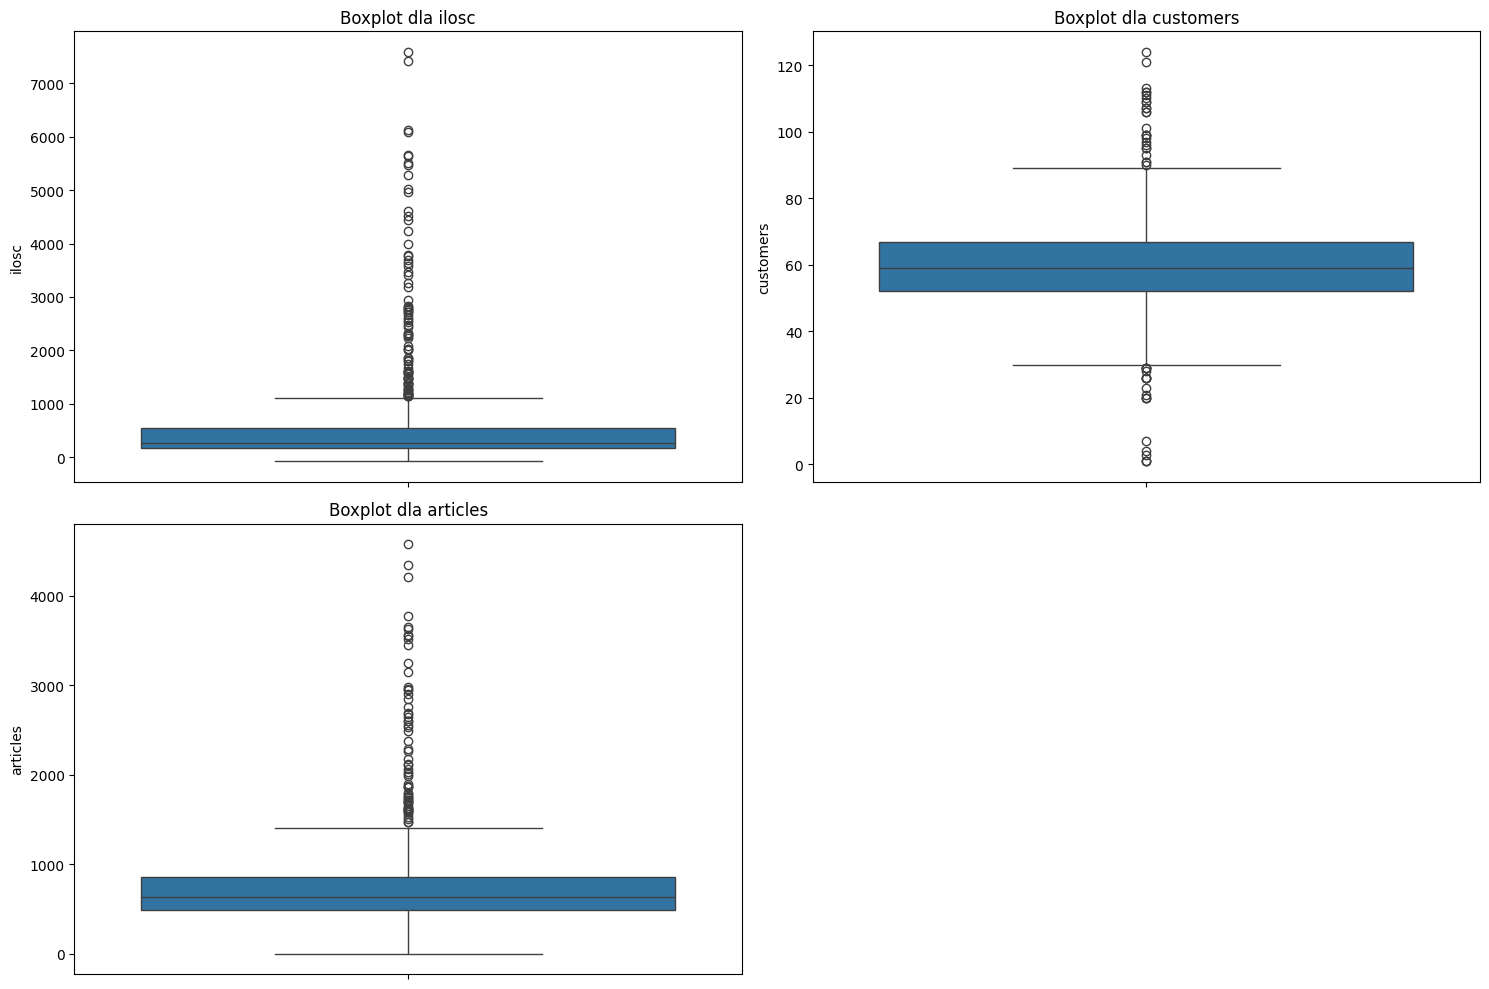

In [37]:
# Wybór kolumn do wizualizacji wartości odstających
columns_to_plot = ['ilosc', 'customers', 'articles']

# Tworzenie wykresów pudełkowych dla wybranych kolumn
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot dla {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

## Stacjonarność danych
Niektóre modele szeregów czasowych, takie jak ARIMA, zakładają, że dane bazowe są stacjonarne. Stacjonarność oznacza, że szereg czasowy ma:

* stałą średnią, a średnia nie jest zależna od czasu
* stałą wariancję, a wariancja nie jest zależna od czasu
* stałą kowariancję, a kowariancja nie jest zależna od czasu

> Jeśli szereg czasowy ma określone (stacjonarne) zachowanie w danym przedziale czasowym, można założyć, że szereg czasowy będzie zachowywać się podobnie w późniejszym czasie.

Szeregi czasowe z trendem i/lub sezonowością nie są stacjonarne. Trend wskazuje, że średnia nie jest stała w czasie, a sezonowość wskazuje, że wariancja nie jest stała w czasie.

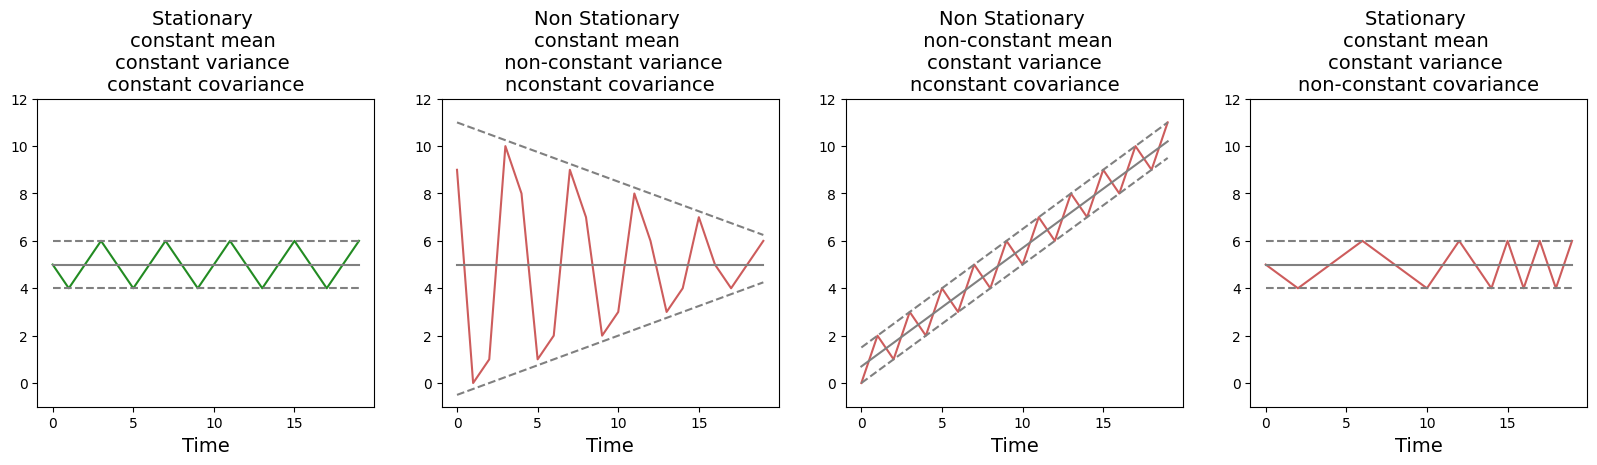

In [38]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)


Sprawdzenie stacjonarności może być przeprowadzone na trzy różne sposoby:
1. **wizualnie**: narysuj wykres szeregu czasowego i sprawdź obecność trendów lub sezonowości
2. **statystyki podstawowe**: podziel szereg czasowy i porównaj średnią oraz wariancję każdej części
3. **test statystyczny**: test rozszerzonego Dickey-Fullera (Augmented Dickey-Fuller test)

### Test Augmented Dickey-Fuller (ADF)

In [39]:
from statsmodels.tsa.stattools import adfuller

# Funkcja do przeprowadzenia testu ADF i wyświetlenia wyników
def adfuller_test(series, column_name):
    result = adfuller(series)
    adf_stat = result[0]
    p_val = result[1]
    crit_values = result[4]
    
    print(f"Wyniki testu ADF dla {column_name}:")
    print(f"Statystyka ADF: {adf_stat}")
    print(f"Wartość p: {p_val}")
    print("Wartości krytyczne:")
    for key, value in crit_values.items():
        print(f"{key}: {value}")
    print("-" * 50)

# Przeprowadź test ADF dla każdej z kolumn
for column in ['ilosc', 'articles', 'customers']:
    adfuller_test(data[column].values, column)


Wyniki testu ADF dla ilosc:
Statystyka ADF: -8.109576076021796
Wartość p: 1.2362381104892274e-12
Wartości krytyczne:
1%: -3.441406876071572
5%: -2.866418015869717
10%: -2.5693678601956718
--------------------------------------------------
Wyniki testu ADF dla articles:
Statystyka ADF: -6.106929591129685
Wartość p: 9.535078863129204e-08
Wartości krytyczne:
1%: -3.441406876071572
5%: -2.866418015869717
10%: -2.5693678601956718
--------------------------------------------------
Wyniki testu ADF dla customers:
Statystyka ADF: -2.4733714153497126
Wartość p: 0.12208849879682787
Wartości krytyczne:
1%: -3.441406876071572
5%: -2.866418015869717
10%: -2.5693678601956718
--------------------------------------------------


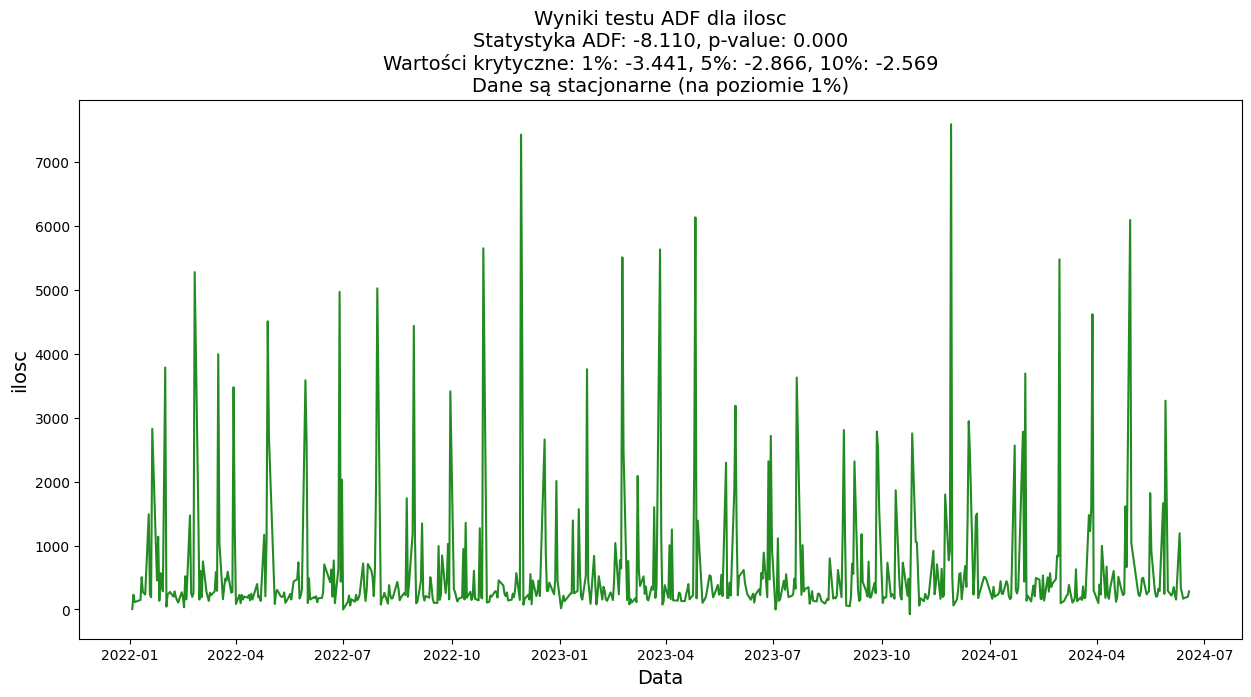

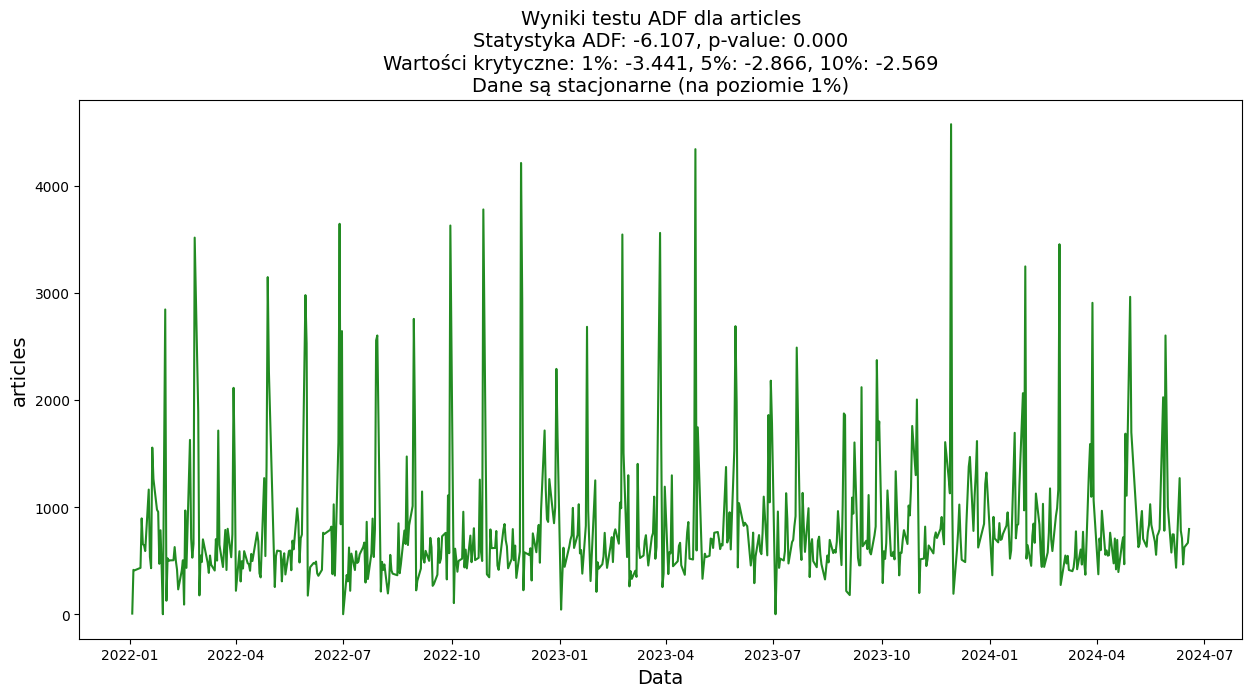

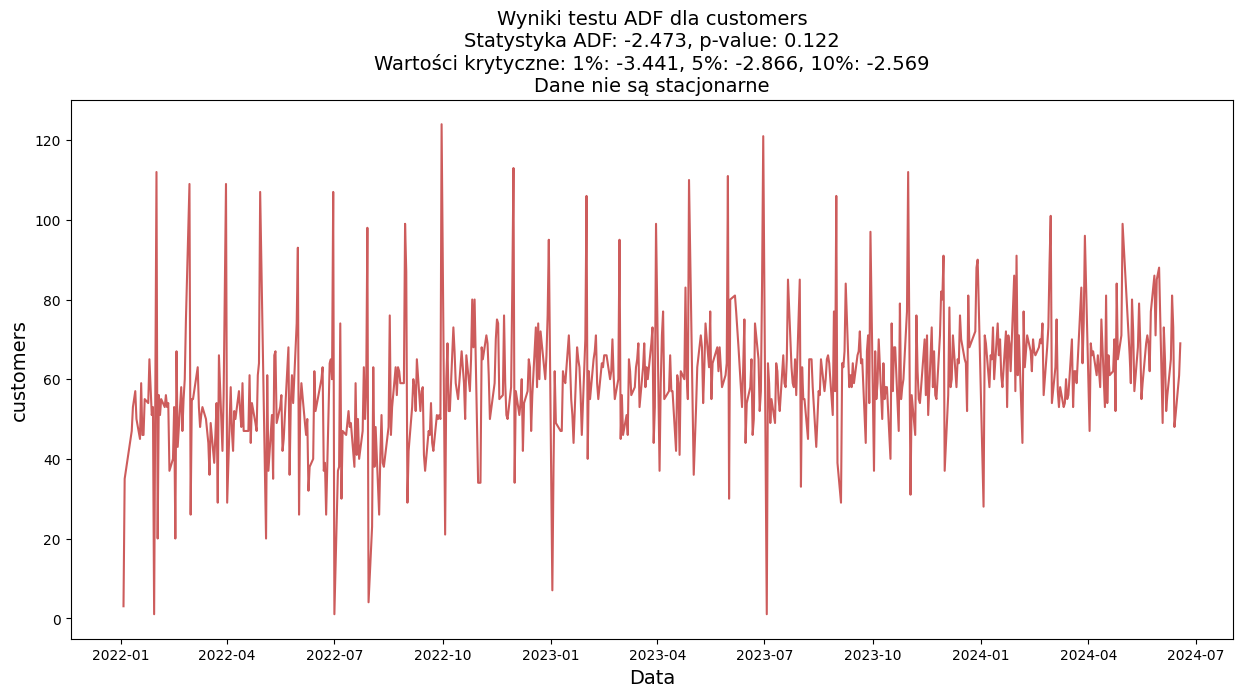

In [49]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

# Funkcja do wizualizacji wyników testu ADF
def visualize_adfuller_results(series, title):
    result = adfuller(series.dropna())
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_values = result[4]

    # Określenie koloru linii w zależności od wyników testu
    if p_val < significance_level:
        if adf_stat < crit_values['1%']:
            linecolor = 'forestgreen'
            stationary = "Dane są stacjonarne (na poziomie 1%)"
        elif adf_stat < crit_values['5%']:
            linecolor = 'gold'
            stationary = "Dane są stacjonarne (na poziomie 5%)"
        elif adf_stat < crit_values['10%']:
            linecolor = 'orange'
            stationary = "Dane są stacjonarne (na poziomie 10%)"
        else:
            linecolor = 'indianred'
            stationary = "Dane nie są stacjonarne"
    else:
        linecolor = 'indianred'
        stationary = "Dane nie są stacjonarne"

    plt.figure(figsize=(15, 7))
    sns.lineplot(x=data['date'], y=series, color=linecolor)
    plt.title(f'Wyniki testu ADF dla {title}\nStatystyka ADF: {adf_stat:0.3f}, p-value: {p_val:0.3f}\n'
              f'Wartości krytyczne: 1%: {crit_values["1%"]:0.3f}, 5%: {crit_values["5%"]:0.3f}, 10%: {crit_values["10%"]:0.3f}\n'
              f'{stationary}', fontsize=14)
    plt.ylabel(title, fontsize=14)
    plt.xlabel('Data', fontsize=14)
    plt.show()

# Pobranie wszystkich kolumn numerycznych
numeric_columns = data.select_dtypes(include=['number']).columns

# Wizualizacja wyników dla każdej kolumny numerycznej
for column in numeric_columns:
    visualize_adfuller_results(data[column], column)


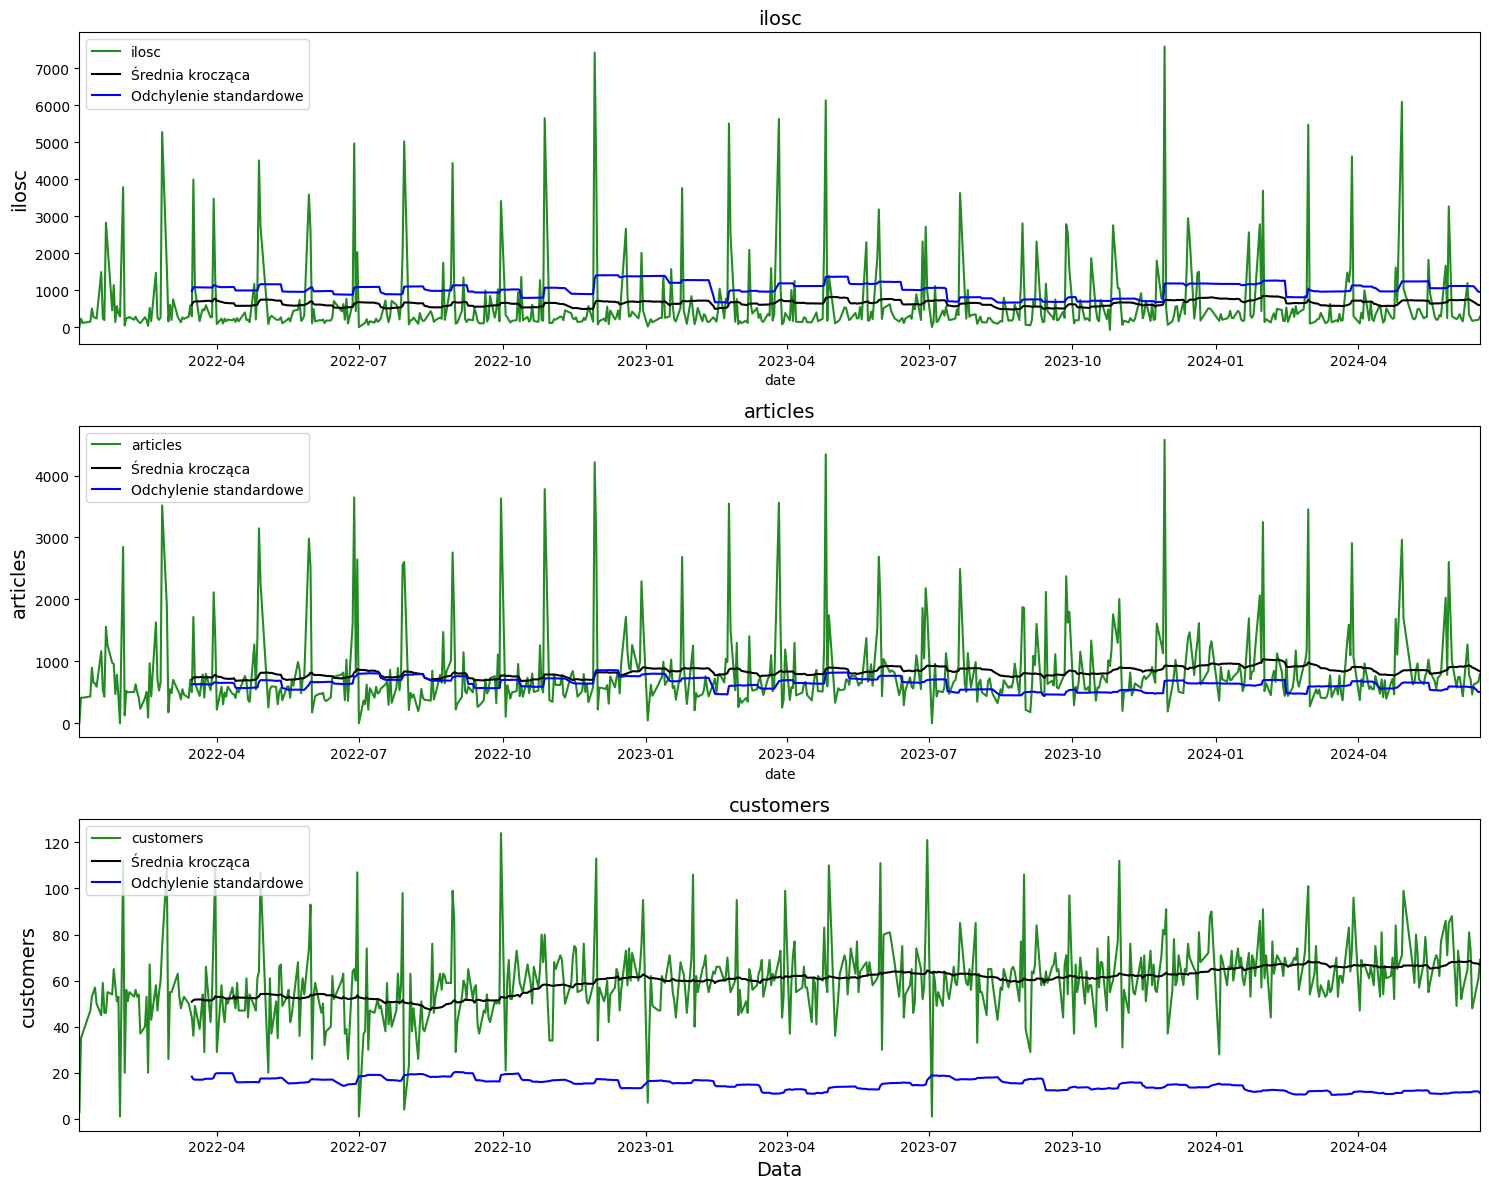

In [53]:
# Ustal rolling window
rolling_window = 52

# Pobierz wszystkie kolumny numeryczne
numeric_columns = data.select_dtypes(include=['number']).columns

# Utwórz subplots
num_plots = len(numeric_columns)
f, ax = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, num_plots * 4))

# Definiowanie zakresu dat na podstawie danych
start_date = data['date'].min()
end_date = data['date'].max()

# Iteruj przez kolumny i twórz wykresy
for i, col in enumerate(numeric_columns):
    sns.lineplot(x=data['date'], y=data[col], ax=ax[i], color='forestgreen', label=f'{col}')
    sns.lineplot(x=data['date'], y=data[col].rolling(rolling_window).mean(), ax=ax[i], color='black', label='Średnia krocząca')
    sns.lineplot(x=data['date'], y=data[col].rolling(rolling_window).std(), ax=ax[i], color='blue', label='Odchylenie standardowe')
    ax[i].set_title(col, fontsize=14)
    ax[i].set_ylabel(col, fontsize=14)
    ax[i].set_xlim([start_date, end_date])
    ax[i].legend(loc='upper left')

# Ustaw wspólny tytuł dla osi X
plt.xlabel('Data', fontsize=14)

# Usuń puste miejsce
plt.tight_layout()
plt.show()


## Dekompozycja zmiennych

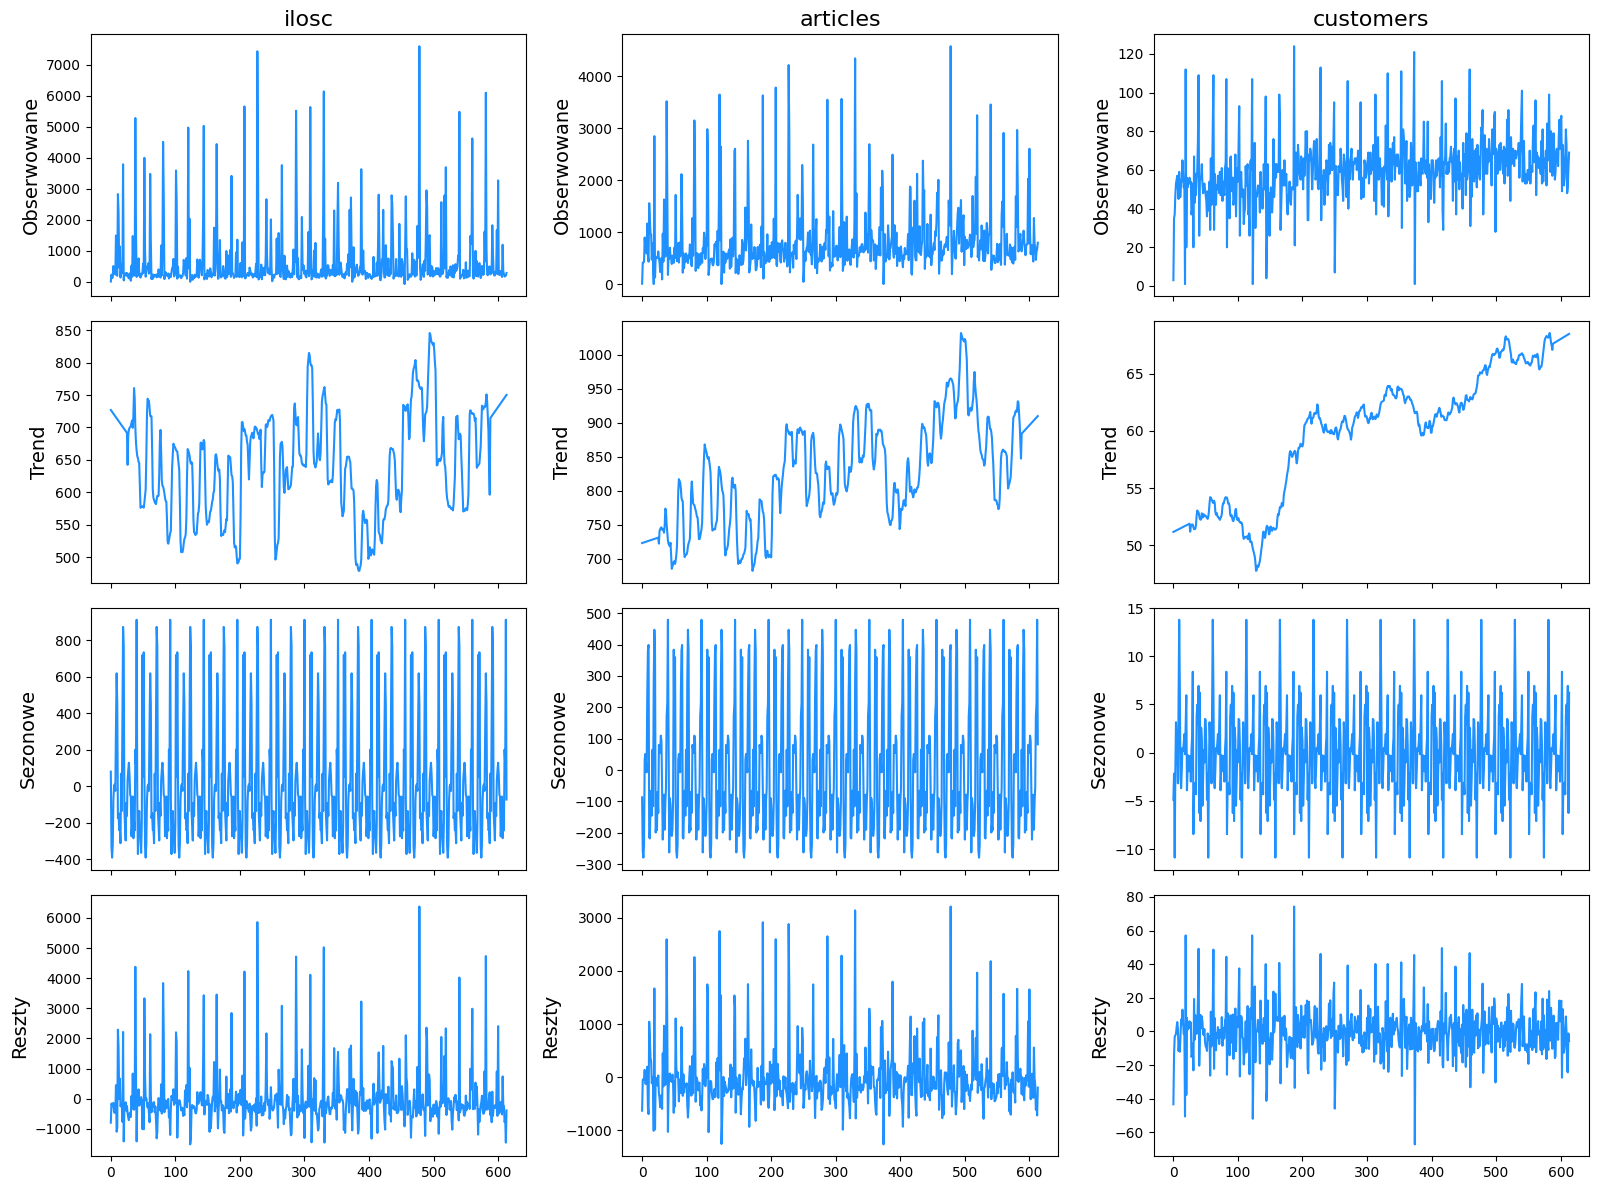

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Dekompozycja sezonowa
decompose_cols = ['ilosc', 'articles', 'customers']
period = 52

for col in decompose_cols:
    decomp = seasonal_decompose(data[col], period=period, model='additive', extrapolate_trend='freq')
    data[f"{col}_trend"] = decomp.trend
    data[f"{col}_seasonal"] = decomp.seasonal
    data[f"{col}_resid"] = decomp.resid

# Tworzenie wykresów
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(16, 12))
columns = ['ilosc', 'articles', 'customers']
titles = ['ilosc', 'articles', 'customers']

for i, col in enumerate(columns):
    res = seasonal_decompose(data[col], period=period, model='additive', extrapolate_trend='freq')

    ax[0, i].set_title(titles[i], fontsize=16)
    res.observed.plot(ax=ax[0, i], legend=False, color='dodgerblue')
    ax[0, i].set_ylabel('Obserwowane', fontsize=14)

    res.trend.plot(ax=ax[1, i], legend=False, color='dodgerblue')
    ax[1, i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2, i], legend=False, color='dodgerblue')
    ax[2, i].set_ylabel('Sezonowe', fontsize=14)

    res.resid.plot(ax=ax[3, i], legend=False, color='dodgerblue')
    ax[3, i].set_ylabel('Reszty', fontsize=14)

plt.tight_layout()
plt.show()

### Wzorce 

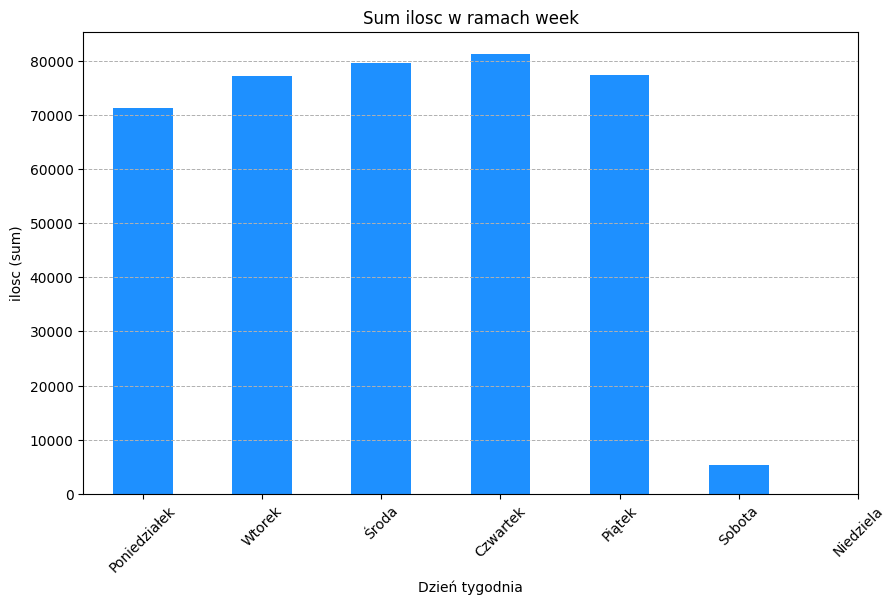

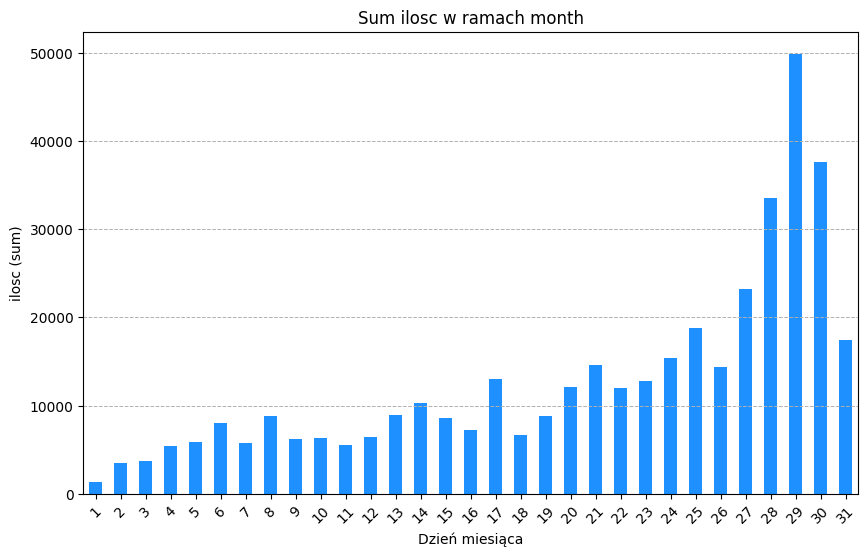

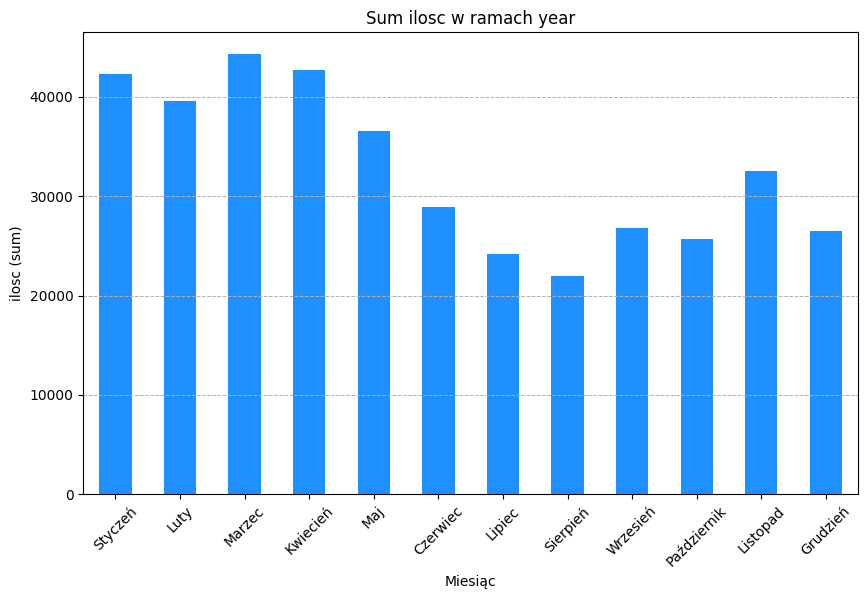

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_aggregation(data, period, column, agg_func):
    """
    Funkcja do obliczania agregacji dla wybranego okresu i metody agregacji.
    
    Parameters:
    data (DataFrame): DataFrame zawierający dane.
    period (str): Okres do analizy ('week', 'month', 'year').
    column (str): Nazwa kolumny do agregacji.
    agg_func (str): Metoda agregacji ('mean', 'sum', 'max', 'min').
    
    Returns:
    Series: Zagregowane dane.
    """
    agg_functions = {
        'mean': data.groupby('period')[column].mean(),
        'sum': data.groupby('period')[column].sum(),
        'max': data.groupby('period')[column].max(),
        'min': data.groupby('period')[column].min()
    }

    if agg_func not in agg_functions:
        raise ValueError("Invalid agg_func. Choose from 'mean', 'sum', 'max', 'min'.")

    return agg_functions[agg_func]

def plot_sales(data, period='week', column='ilosc', agg_func='mean'):
    """
    Funkcja do wykresu danych w ramach danego okresu (tydzień, miesiąc, rok) z wybraną metodą agregacji.
    
    Parameters:
    data (DataFrame): DataFrame zawierający dane z kolumną 'date' i kolumną do agregacji.
    period (str): Okres do analizy ('week', 'month', 'year').
    column (str): Nazwa kolumny do agregacji.
    agg_func (str): Metoda agregacji ('mean', 'sum', 'max', 'min', itp.).
    """
    # Słownik z odpowiednimi ustawieniami dla różnych okresów
    period_settings = {
        'week': {
            'period': data['date'].dt.dayofweek,
            'labels': ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota', 'Niedziela'],
            'xlabel': 'Dzień tygodnia'
        },
        'month': {
            'period': data['date'].dt.day,
            'labels': np.arange(1, 32),
            'xlabel': 'Dzień miesiąca'
        },
        'year': {
            'period': data['date'].dt.month,
            'labels': ['Styczeń', 'Luty', 'Marzec', 'Kwiecień', 'Maj', 'Czerwiec', 'Lipiec', 'Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień'],
            'xlabel': 'Miesiąc'
        }
    }
    
    # Sprawdzenie poprawności wybranego okresu
    if period not in period_settings:
        raise ValueError("Invalid period. Choose from 'week', 'month', or 'year'.")
    
    # Dodanie kolumny z odpowiednim okresem do danych
    data['period'] = period_settings[period]['period']
    
    # Obliczenie agregacji dla wybranego okresu i kolumny
    sales_agg = calculate_aggregation(data, period, column, agg_func)
    
    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))
    sales_agg.plot(kind='bar', color='dodgerblue')
    plt.xlabel(period_settings[period]['xlabel'])
    plt.ylabel(f'{column} ({agg_func})')
    plt.title(f'{agg_func.capitalize()} {column} w ramach {period}')
    plt.xticks(ticks=np.arange(len(period_settings[period]['labels'])), labels=period_settings[period]['labels'], rotation=45)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.show()

# Średnia 'ilosc' w ramach tygodnia
plot_sales(data, period='week', column='ilosc', agg_func='sum')

# Suma 'ilosc' w ramach miesiąca
plot_sales(data, period='month', column='ilosc', agg_func='sum')

# Maksymalna 'ilosc' w ramach roku
plot_sales(data, period='year', column='ilosc', agg_func='sum')


## Sprawdzenie sezonowości

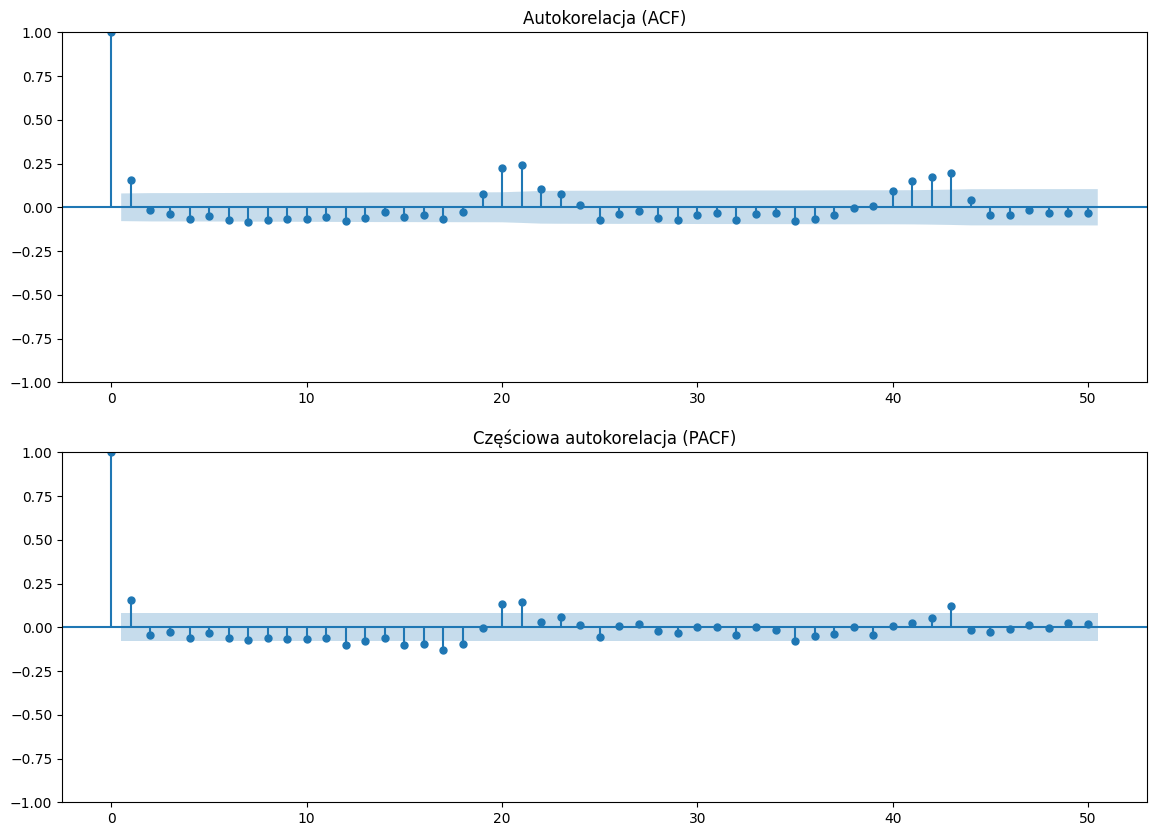

In [5]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Wykres ACF
sm.graphics.tsa.plot_acf(data['ilosc'], lags=50, ax=ax[0])
ax[0].set_title('Autokorelacja (ACF)')

# Wykres PACF
sm.graphics.tsa.plot_pacf(data['ilosc'], lags=50, ax=ax[1])
ax[1].set_title('Częściowa autokorelacja (PACF)')

plt.show()
